In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
# import pandas library
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
!pip install -Uqq ipdb
import ipdb

In [219]:
df = pd.read_csv('/content/drive/MyDrive/Data/dk_orig.csv')
print(df.head())
print('\n')
print(df.tail())
print('\n')
print(df.dtypes)
print(df.shape)

                       start                        end    load
0  2015-01-01 00:00:00+00:00  2015-01-01 01:00:00+00:00  3211.0
1  2015-01-01 01:00:00+00:00  2015-01-01 02:00:00+00:00  3100.0
2  2015-01-01 02:00:00+00:00  2015-01-01 03:00:00+00:00  2980.0
3  2015-01-01 03:00:00+00:00  2015-01-01 04:00:00+00:00  2933.0
4  2015-01-01 04:00:00+00:00  2015-01-01 05:00:00+00:00  2942.0


                           start                        end    load
48929  2020-07-31 19:00:00+00:00  2020-07-31 20:00:00+00:00  3353.0
48930  2020-07-31 20:00:00+00:00  2020-07-31 21:00:00+00:00  3242.0
48931  2020-07-31 21:00:00+00:00  2020-07-31 22:00:00+00:00  3015.0
48932  2020-07-31 22:00:00+00:00  2020-07-31 23:00:00+00:00  2813.0
48933  2020-07-31 23:00:00+00:00  2020-08-01 00:00:00+00:00  2695.0


start     object
end       object
load     float64
dtype: object
(48934, 3)


In [220]:
df.drop(columns = 'end', inplace = True)

In [221]:
df.rename(columns = {'start': 'date'}, inplace = True)
#convert data type to datetime
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)
print('\n')

date    datetime64[ns, UTC]
load                float64
dtype: object




In [222]:
# Set index to date time index and explicitly set hourly frequncy
df = df.set_index('date')
df = df.asfreq('H')
# filter data from 2017 to 2019
df = df.loc['2017-01-01 00:00:00+00:00' :'2019-12-31 23:00:00+00:00', :]

# check for missing values
print(df.isna().sum())
print(df.head(2))
print('\n')
print(df.tail(2))

load    0
dtype: int64
                             load
date                             
2017-01-01 00:00:00+00:00  2743.0
2017-01-01 01:00:00+00:00  2595.0


                             load
date                             
2019-12-31 22:00:00+00:00  3309.0
2019-12-31 23:00:00+00:00  3316.0


In [223]:
#check for invalid values
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

load    True
dtype: bool

In [224]:
df.describe()

,load
count,26280.000000
mean,3789.909589
std,735.707174
min,1693.000000
25%,3190.000000
50%,3756.500000
75%,4366.000000
max,8088.000000


(array([5.500e+01, 4.127e+03, 7.515e+03, 6.541e+03, 5.944e+03, 2.061e+03,
        3.100e+01, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([1693. , 2332.5, 2972. , 3611.5, 4251. , 4890.5, 5530. , 6169.5,
        6809. , 7448.5, 8088. ]),
 <BarContainer object of 10 artists>)

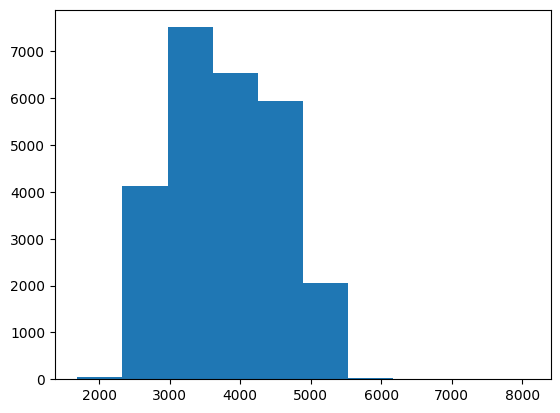

In [225]:
plt.hist(df['load'])

<Axes: xlabel='date'>

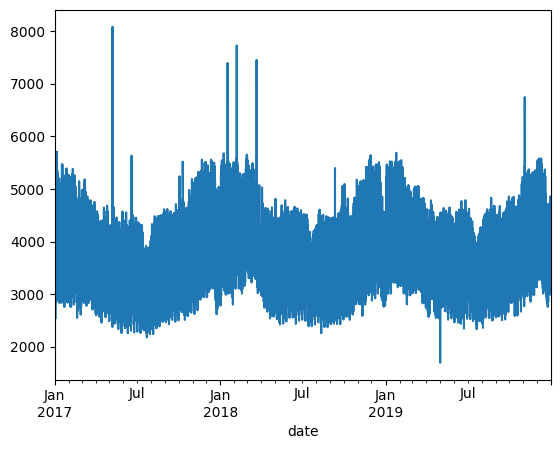

In [226]:
df['load'].plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe96ad66bc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe96ad67100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe96ad66920>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe96ad67640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe96ad678e0>],
 'means': []}

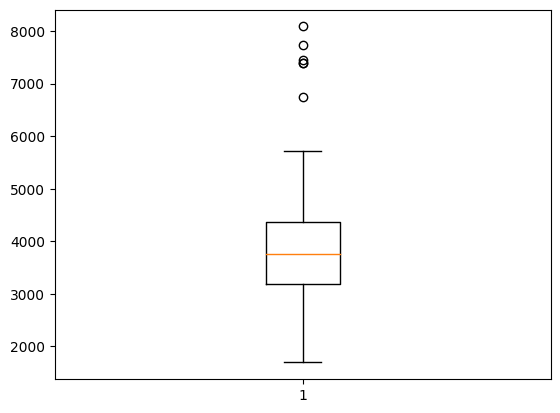

In [227]:
plt.boxplot(df['load'])

In [228]:
# stationarity test
df_stationarityTest = adfuller(df['load'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  8.597794557817729e-27


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


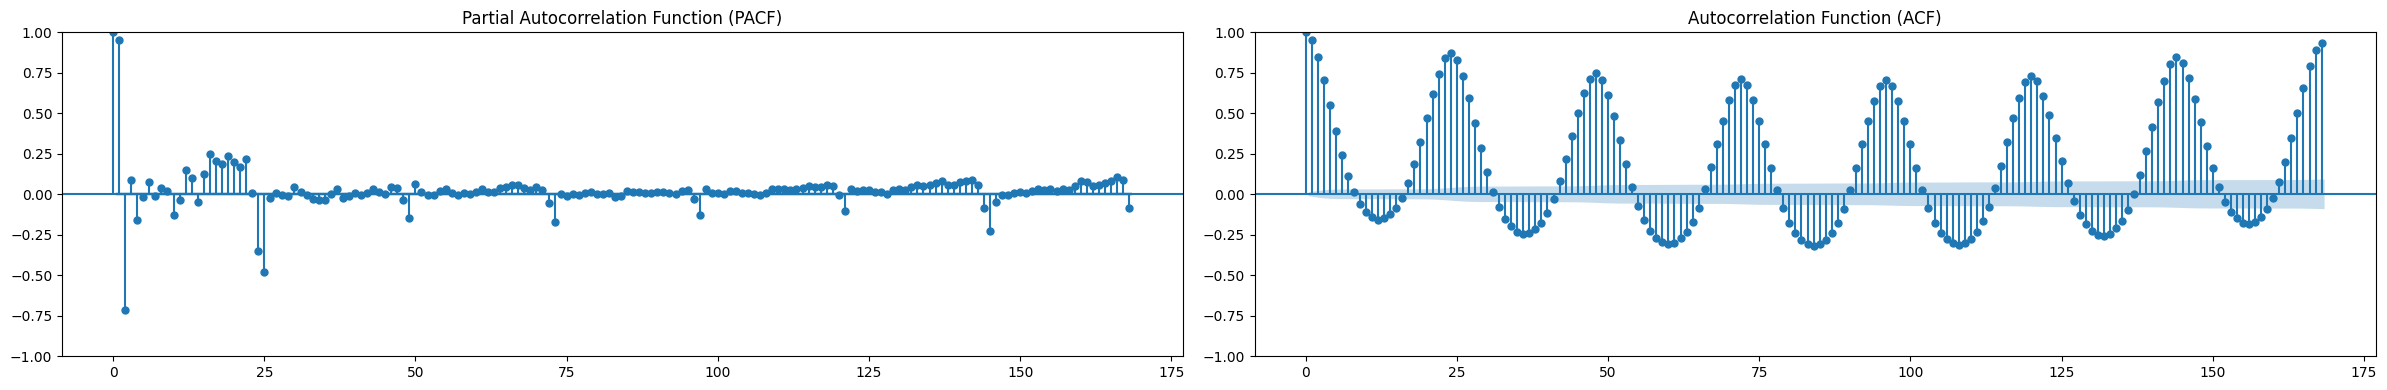

In [229]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 4))
# Plot PACF
plot_pacf(df['load'], lags=168, ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
# Plot ACF
plot_acf(df['load'], lags=168, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

In [247]:
#rolling window prediction
#with datetime index
init_start_date = pd.to_datetime("2017-01-01 00:00:00+00:00")
init_end_date = pd.to_datetime("2018-12-31 23:00:00+00:00")

test_start_date = "2019-01-01 00:00:00+00:00"
test_end_date = "2019-01-31 23:00:00+00:00"

window_size = int((init_end_date - init_start_date) / pd.Timedelta(hours=1) + 1)

step_size = 24

results = pd.DataFrame(columns=['timestamp', 'actual_load', 'predicted_load'])

for i in pd.date_range(start = test_start_date, end = test_end_date, freq='24H'):
    # Extract the training data for the current window
    train_data = df.loc[i - pd.DateOffset(hours = window_size) : i - pd.DateOffset(hours = 1)]

    # Fit the AR model to the training data
    ar_model = AutoReg(train_data['load'], lags=24).fit()

    # Make predictions for the next 24 hours
    start_index = train_data.index[-1] + pd.DateOffset(hours = 1)
    end_index = start_index + pd.DateOffset(hours = step_size - 1)
    pred = ar_model.predict(start=start_index, end=end_index, dynamic=False)

    # Extract the timestamp and actual load for the next 24 hours
    next_24_hours = df.loc[i : i + pd.DateOffset(hours = step_size - 1)]

    # Create a DataFrame with the predicted load for the next 24 hours
    predicted_data = pd.DataFrame({'timestamp': next_24_hours.index,
                                   'actual_load': next_24_hours['load'],
                                   'predicted_load': pred})
    # Append the predicted data to the results DataFrame
    results = pd.concat([results, predicted_data], ignore_index=True)

#results = results.set_index('timestamp')
results

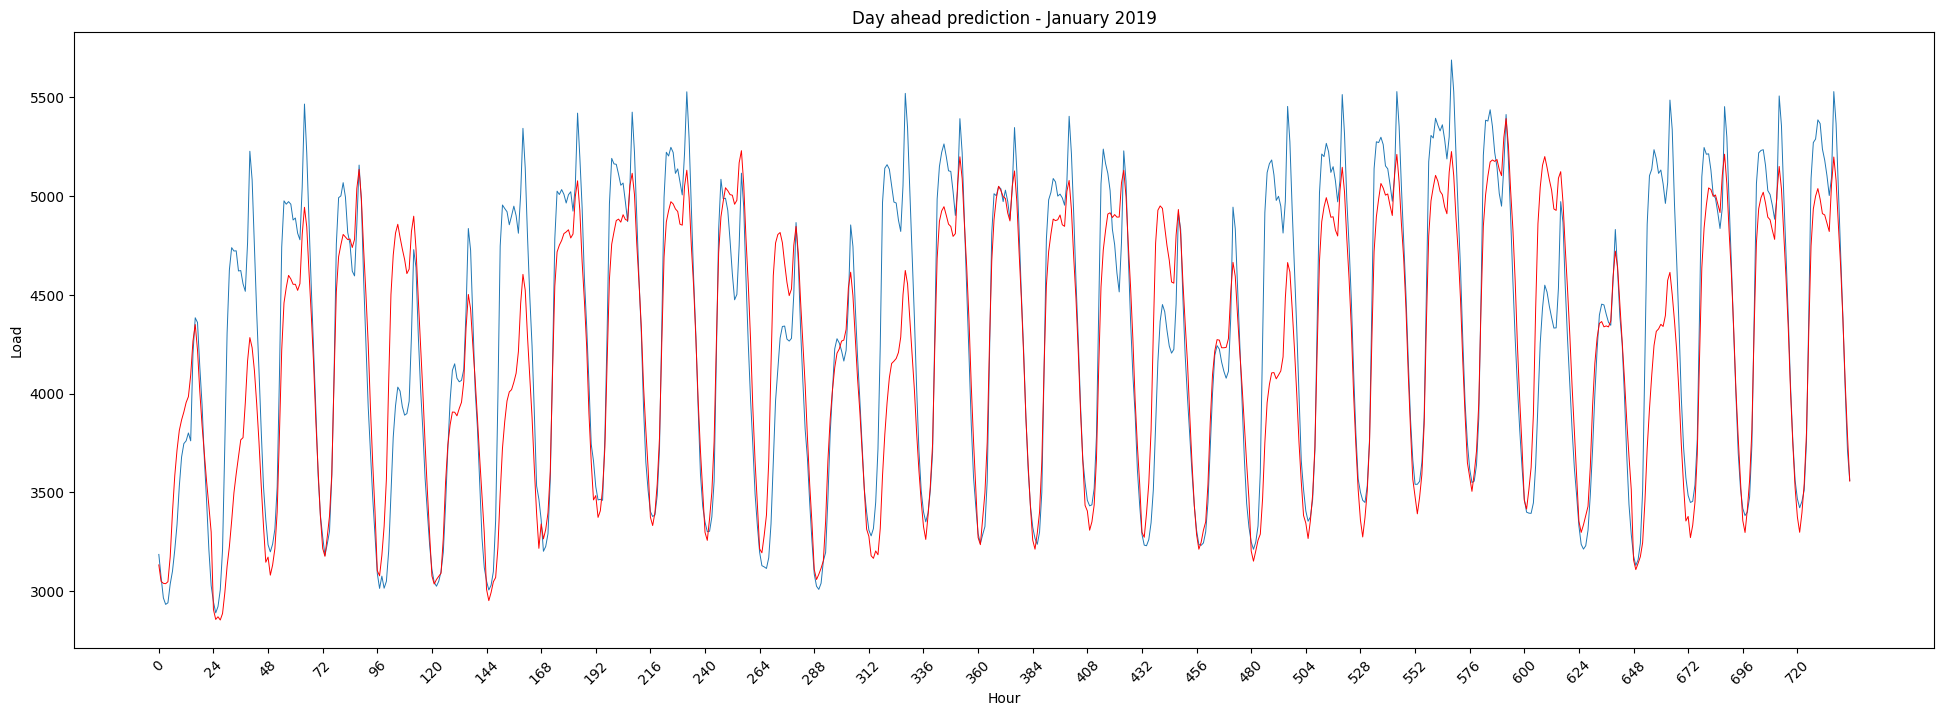

In [249]:
results.isetitem(results.columns.get_loc('timestamp'), pd.to_datetime(results.loc[:,'timestamp']))
x=list(results.index)

plt.figure(figsize=(24,8))
plt.plot(x,results['actual_load'], linewidth=0.7)
plt.plot(x,results['predicted_load'], color='red', linewidth=0.7)
plt.xticks(np.arange(0,744,24), rotation = 45, fontsize=10)
plt.title(f"Day ahead prediction - {results['timestamp'].dt.month_name()[0]} {results['timestamp'].dt.year.iloc[0]}")
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()

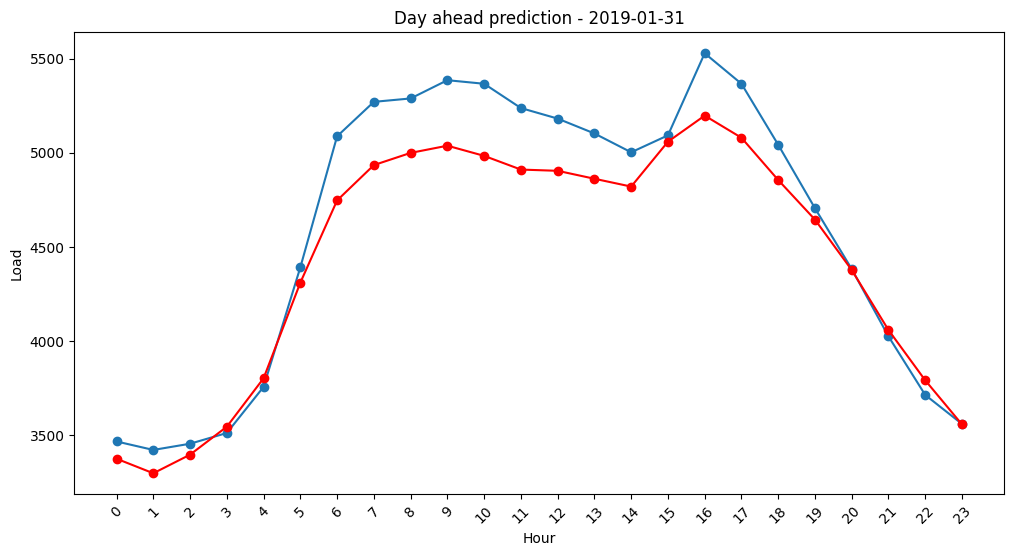

In [250]:
results.isetitem(results.columns.get_loc('timestamp'), pd.to_datetime(results.loc[:,'timestamp']))

plt.figure(figsize=(12,6))
plt.plot(results.tail(24)['timestamp'].dt.hour,results.tail(24)['actual_load'], marker = 'o')
plt.plot(results.tail(24)['timestamp'].dt.hour,results.tail(24)['predicted_load'], color='red', marker = 'o')
plt.xticks(results.tail(24)['timestamp'].dt.hour, rotation = 45)
plt.title(f"Day ahead prediction - {results.tail(24)['timestamp'].dt.date.iloc[0]}")
plt.xlabel("Hour")
plt.ylabel("Load")
plt.show()